In [5]:
import sys
sys.path.append('../')

import torch
import random
import math
import scienceplots
import matplotlib

from ring import *
from exponential_graph import *
from one_peer_exponential_graph import *
from adic_graph import *
from torus import *
from one_peer_undirected_equidyn import *
from one_peer_directed_equidyn import *

from undirected_equitopo import *

import pickle
from matplotlib import rc

In [2]:
torch.set_default_dtype(torch.float64)
rc('text', usetex=True)

In [ ]:
def UEquiStatic(n, seed=0, eps=None, p=None, M=None):
    """A function that generates static topology for undirected graphs satisfying
        Pr( ||Proj(W)||_2 < eps ) >= 1 - p  
    Args:
        n: number of nodes
        seed: an integer used as the random seed
        eps: the upper bound of l2 norm
        p: the probability that the l2 norm is bigger than eps
        M: conmunnication cost. If M is not given, M is calculated from eps and p. 
    Returns:
        K: a numpy array that specifies the communication topology.
        As: a sequence of basis index
    """
    if M == None:
        M = int(8 * math.log(2 * n / p) / 3 / eps**2)
    # generating M graphs
    np.random.seed(seed)
    As = np.random.choice(np.arange(1, n), size=M, replace=True)
    Ws = np.zeros((n,n))
    for a in As:
        W = np.zeros((n,n))
        for i in range(1, n + 1):
            j =  (i + a) % n
            if j == 0: j = n
            W[i-1, j-1] = (n - 1) / n
            W[i-1, i-1] = 1 / n
        Ws += W + W.T
    K = Ws / M / 2
    #assert is_doubly_stochastic(K)
    #assert is_symmetric(K)
    return K, As


# 論文用の図

In [3]:
colors = ["" for _ in range(10)]

colors[0] = "black"
colors[1] = "skyblue"
colors[2] = "green"
colors[3] = "red"
colors[4] = "orange"
colors[5] = "gold"

colors[6] = "blue"
colors[7] = "blue"
colors[8] = "blue"
colors[9] = "blue"


In [46]:
plt.style.use(['science','ieee'])

n_nodes_list = [100, 500, 1000]
torus_n_nodes_list = [(10, 10), (20, 25), (25, 40)]
seed = 0

diff = {}

for i in range(len(n_nodes_list)):
    n_nodes = n_nodes_list[i]
    
    print(n_nodes)
    torch.manual_seed(seed)
    init_x = torch.randn(n_nodes)
    mean_x = init_x.sum() / n_nodes

    graphs = {"Exp.": ExponentialGraph(n_nodes), "Ring": Ring(n_nodes),  "1-peer U-EquiDyn": OnePeerUndirectedEquiDyn(n_nodes, seed=seed), "U-EquiTopo": UndirectedEquiTopo(n_nodes, m=math.ceil(math.log2(n_nodes)/2), seed=seed), "1-peer ADIC": AdicGraph(n_nodes, seed=seed), "2-peer ADIC": AdicGraph(n_nodes, max_degree=2, seed=seed)}

    diff[n_nodes] = {}

    for g_name in graphs:
        x = init_x.clone()
        g = graphs[g_name]
        diff[n_nodes][g_name] = [torch.norm(x - mean_x)**2 / n_nodes]
    
        for _ in range(100):
            x = g.get_w().matmul(x)
            diff[n_nodes][g_name].append(torch.norm(x - mean_x)**2 / n_nodes)

100
500
1000


In [47]:
for i in range(len(n_nodes_list)):
    n_nodes = n_nodes_list[i]
    
    print(n_nodes)
    torch.manual_seed(seed)
    init_x = torch.randn(n_nodes)
    mean_x = init_x.sum() / n_nodes

    K, _ = UEquiStatic(n_nodes, seed=seed, M=math.ceil(math.log2(n_nodes)/2))
    K = torch.tensor(K)
    
    x = init_x.clone()
    g_name = "UEquiStatic"
    diff[n_nodes][g_name] = [torch.norm(x - mean_x)**2 / n_nodes]
    
    for _ in range(100):
        x = K.matmul(x)
        diff[n_nodes][g_name].append(torch.norm(x - mean_x)**2 / n_nodes)
        
graphs["UEquiStatic"] = ""

100
500
1000


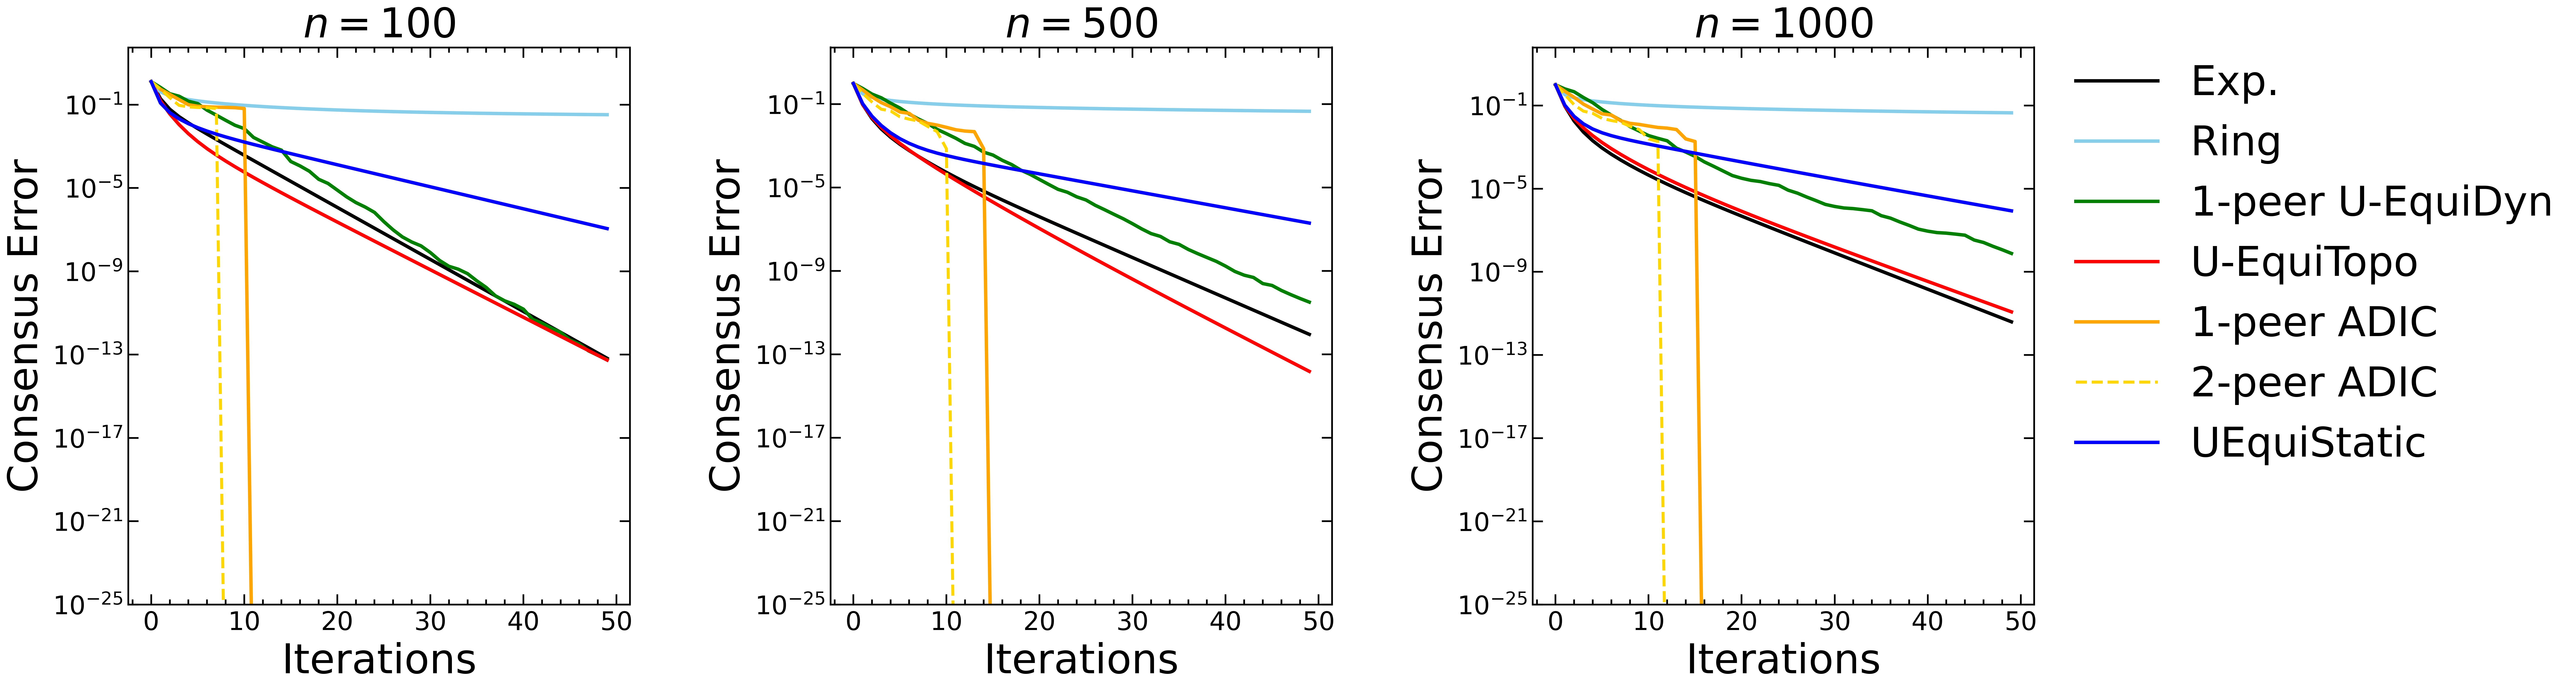

In [48]:
plt.style.use(['science', 'notebook'])

#colors = ["red", "brown", "orange", "yellow", "black", "pink", "blue", "blue", "blue"]
plt.figure(figsize=(5*4,6))

plt.subplots_adjust(wspace=0.4)

for i in range(len(n_nodes_list)):
    n_nodes = n_nodes_list[i]
    ax = plt.subplot(1, len(n_nodes_list), i+1)
    

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
        
    for g_name, color in zip(graphs, colors):
    
        if g_name =="2-peer ADIC":
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=1.75, ls="dashed", alpha=1.0)
        elif g_name =="3-peer ADIC":
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=1.75, ls="dotted", alpha=1.0)
        elif g_name =="4-peer ADIC":
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=1.75, ls="dashdot", alpha=1.0)
        else:
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=2, alpha=1.0)
        
        #plt.plot(diff[n_nodes][g_name][:50], label=g_name, lw=2.0)
        
    plt.title(f"$n={n_nodes}$", fontsize=24)
    plt.yscale("log")
    plt.ylabel("Consensus Error", fontsize=24)
    plt.xlabel("Iterations", fontsize=24)
    plt.ylim(ymin=10**(-25))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=24)


In [13]:
plt.style.use(['science','ieee'])

n_nodes_list = [25,50,100]
seed = 0

diff = {}

for i in range(len(n_nodes_list)):
    n_nodes = n_nodes_list[i]
    
    print(n_nodes)
    torch.manual_seed(seed)
    init_x = torch.randn(n_nodes)
    mean_x = init_x.sum() / n_nodes

    graphs = {"Exp.": ExponentialGraph(n_nodes), "Ring": Ring(n_nodes),  "1-peer U-EquiDyn": OnePeerUndirectedEquiDyn(n_nodes, seed=seed), "U-EquiTopo": UndirectedEquiTopo(n_nodes, m=math.ceil(math.log2(n_nodes)/2), seed=seed), "1-peer ADIC": AdicGraph(n_nodes, seed=seed), "2-peer ADIC": AdicGraph(n_nodes, max_degree=2, seed=seed)}

    diff[n_nodes] = {}

    for g_name in graphs:
        x = init_x.clone()
        g = graphs[g_name]
        diff[n_nodes][g_name] = [torch.norm(x - mean_x)**2 / n_nodes]
    
        for _ in range(100):
            x = g.get_w().matmul(x)
            diff[n_nodes][g_name].append(torch.norm(x - mean_x)**2 / n_nodes)

25
50
100


In [42]:
for i in range(len(n_nodes_list)):
    n_nodes = n_nodes_list[i]
    
    print(n_nodes)
    torch.manual_seed(seed)
    init_x = torch.randn(n_nodes)
    mean_x = init_x.sum() / n_nodes

    K, _ = UEquiStatic(n_nodes, seed=seed, M=math.ceil(math.log2(n_nodes)/2))
    K = torch.tensor(K)
    
    x = init_x.clone()
    g_name = "UEquiStatic"
    diff[n_nodes][g_name] = [torch.norm(x - mean_x)**2 / n_nodes]
    
    for _ in range(100):
        x = K.matmul(x)
        diff[n_nodes][g_name].append(torch.norm(x - mean_x)**2 / n_nodes)
        
graphs["UEquiStatic"] = ""

25
50
100


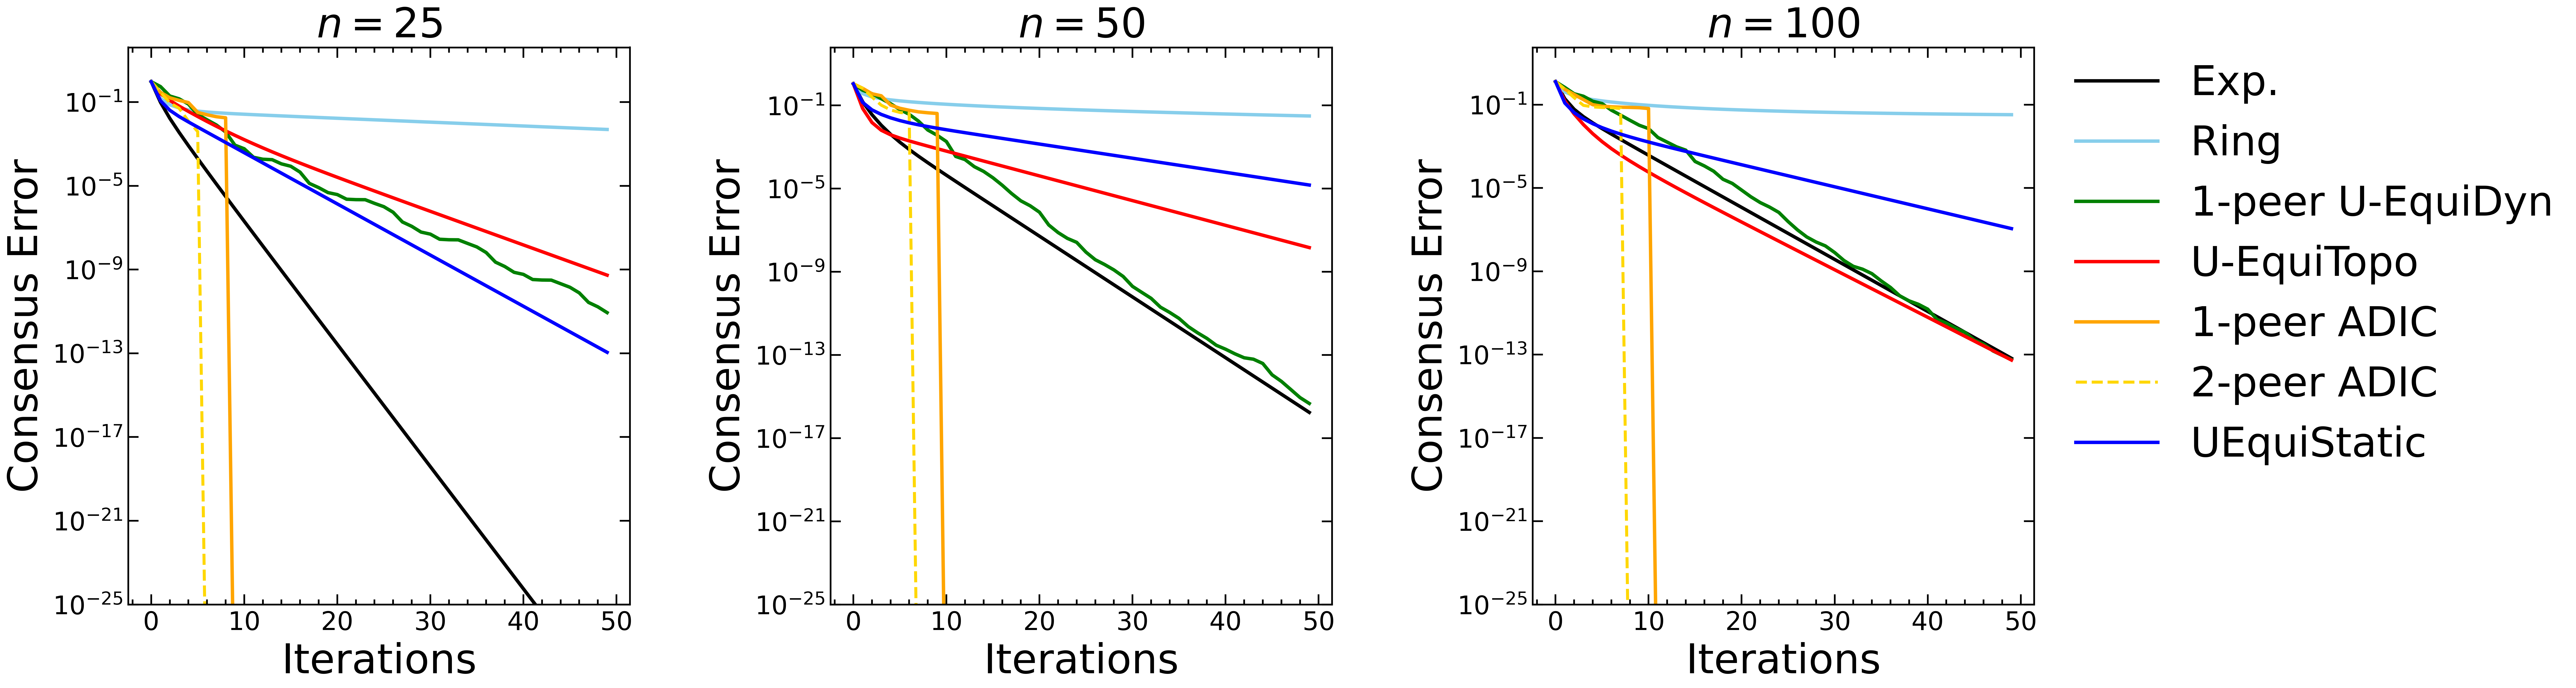

In [45]:
plt.style.use(['science', 'notebook'])

#colors = ["red", "brown", "orange", "yellow", "black", "pink", "blue", "blue", "blue"]
plt.figure(figsize=(5*4,6))

plt.subplots_adjust(wspace=0.4)

for i in range(len(n_nodes_list)):
    n_nodes = n_nodes_list[i]
    ax = plt.subplot(1, len(n_nodes_list), i+1)
    

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
        
    for g_name, color in zip(graphs, colors):
    
        if g_name =="2-peer ADIC":
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=1.75, ls="dashed", alpha=1.0)
        elif g_name =="3-peer ADIC":
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=1.75, ls="dotted", alpha=1.0)
        elif g_name =="4-peer ADIC":
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=1.75, ls="dashdot", alpha=1.0)
        else:
            plt.plot(diff[n_nodes][g_name][:50], label=g_name, color=color, lw=2, alpha=1.0)
        
        #plt.plot(diff[n_nodes][g_name][:50], label=g_name, lw=2.0)
        
    plt.title(f"$n={n_nodes}$", fontsize=24)
    plt.yscale("log")
    plt.ylabel("Consensus Error", fontsize=24)
    plt.xlabel("Iterations", fontsize=24)
    plt.ylim(ymin=10**(-25))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=24)


In [18]:
len(graphs["U-EquiTopo"].w_list[0][0].nonzero())

<ipython-input-18-71ac672c2e44>:1: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  len(graphs["U-EquiTopo"].w_list[0][0].nonzero())


9

In [19]:
len(graphs["Exp."].w_list[0][0].nonzero())

8

In [26]:
g = UndirectedEquiTopo(25, m=1)
g.w_list[0][0]

tensor([0.0400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.4800, 0.4800, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [38]:
K, _ = UEquiStatic(25, seed=0, M=2)
K

array([[0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  ,
        0.  , 0.24, 0.24, 0.  , 0.  , 0.24, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.24,
        0.  , 0.  , 0.24, 0.24, 0.  , 0.  , 0.24, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.24, 0.  , 0.  , 0.24, 0.24, 0.  , 0.  , 0.24, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.24, 0.  , 0.  , 0.24, 0.24, 0.  , 0.  , 0.24, 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.24, 0.  , 0.  , 0.24, 0.24, 0.  , 0.  , 0.24, 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.24, 0.  , 0.  , 0.24, 0

In [39]:
g = UndirectedEquiTopo(25, seed=0, m=2)
g.w_list[0]

tensor([[0.0400, 0.2400, 0.0000, 0.0000, 0.2400, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.2400, 0.0000, 0.0000, 0.2400],
        [0.2400, 0.0400, 0.2400, 0.0000, 0.0000, 0.2400, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2400, 0.0000, 0.0000],
        [0.0000, 0.2400, 0.0400, 0.2400, 0.0000, 0.0000, 0.2400, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2400, 0.0000],
        [0.0000, 0.0000, 0.2400, 0.0400, 0.2400, 0.0000, 0.0000, 0.2400, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2400],
        [0.2400, 0.0000, 0.0000, 0.2400, 0.0400, 0.2400, 0.0000, 0.0000, 0.2400,
       